## *Minimal* notebook for training ML models on the dataset for Open-Source Reservoir (CMG simulations)

Code in this notebook trains a single model on the Train subset of the dataset and evalutes it on the Test subset of the dataset.

-------

*Written by: Dmitry Duplyakin (dmitry.duplyakin@nrel.gov) in collaboration with the National Renewable Energy Laboratories.*

*Full team: Dmitry Duplyakin, Koenraad F. Beckers, Drew L. Siler, Michael J. Martin, Henry E. Johnston*

### Necessary configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import uuid
from datetime import datetime
import glob
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
import math
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold

loglevel = 'WARNING'
logging.basicConfig(level=os.environ.get("LOGLEVEL", loglevel))

# Import config file that is specific to CMG dataset
sys.path.append('../data/OpenSourceReservoir-CMG')
sys.path.append('../')

import config_cmg as config
from reservoir.reservoir import Reservoir, ReservoirPredictionEnsemble
from polynomial import get_polynomial_func

%matplotlib inline
%config InlineBackend.figure_format='retina'

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Loading data (from Xcel files to Pandas dataframes)

In [2]:
cases_list = []

# This code assumes file names like: ../data/OpenSourceReservoir-CMG/OSR_<case #>.xlsx
data_dir = "../data/OpenSourceReservoir-CMG/"
filename_pattern = "OSR_*.xlsx"
cases = dict([(int(f.split("/")[-1].replace(".xlsx","").replace("OSR_", "")), f) for f 
         in glob.glob(data_dir + filename_pattern)])

for case in sorted(cases):

    file = cases[case]
    print("Processing: case %d, file %s" % (case, file))
    
    config_for_case = config
    
    # Override some config setting for this particular vis/analysis
    config_for_case.flow_unit = "kg/day"
    config_for_case.timeseries_file = file

    cases_list.append(Reservoir(config_for_case, energy_calc=False))

Processing: case 0, file ../data/OpenSourceReservoir-CMG/OSR_00000.xlsx
Processing: case 1, file ../data/OpenSourceReservoir-CMG/OSR_00001.xlsx
Processing: case 2, file ../data/OpenSourceReservoir-CMG/OSR_00002.xlsx
Processing: case 3, file ../data/OpenSourceReservoir-CMG/OSR_00003.xlsx
Processing: case 4, file ../data/OpenSourceReservoir-CMG/OSR_00004.xlsx
Processing: case 5, file ../data/OpenSourceReservoir-CMG/OSR_00005.xlsx
Processing: case 6, file ../data/OpenSourceReservoir-CMG/OSR_00006.xlsx
Processing: case 7, file ../data/OpenSourceReservoir-CMG/OSR_00007.xlsx
Processing: case 8, file ../data/OpenSourceReservoir-CMG/OSR_00008.xlsx
Processing: case 9, file ../data/OpenSourceReservoir-CMG/OSR_00009.xlsx
Processing: case 10, file ../data/OpenSourceReservoir-CMG/OSR_00010.xlsx
Processing: case 11, file ../data/OpenSourceReservoir-CMG/OSR_00011.xlsx
Processing: case 12, file ../data/OpenSourceReservoir-CMG/OSR_00012.xlsx
Processing: case 13, file ../data/OpenSourceReservoir-CMG/OSR

### Combine different scenarios into an ensemble

In [3]:
ens = ReservoirPredictionEnsemble(config, cases_list)    
ens.scale()

# To see individual scaled timeseries, do the following:
# ens[0].scaled_timeseries

### Train and evaluate networks

2021-12-30 12:56:23.556608: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2021-12-30 12:56:23.562354: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3000000000 Hz
2021-12-30 12:56:23.564054: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b4b17b3d70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-30 12:56:23.564074: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-30 12:56:23.564184: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


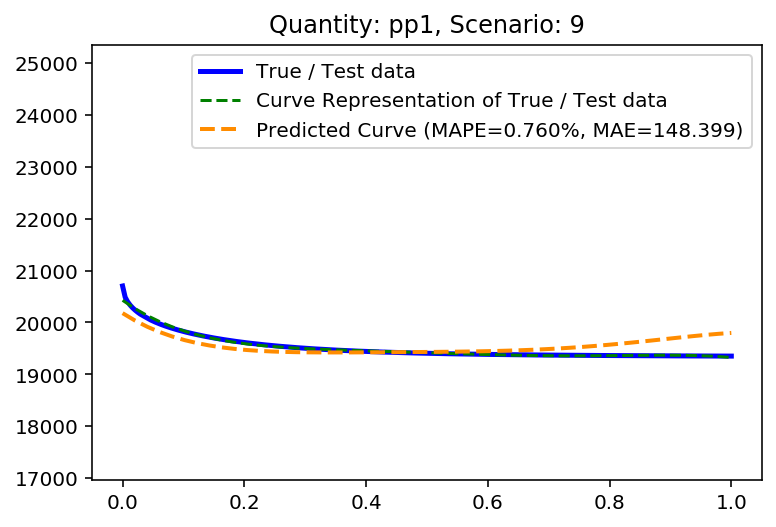

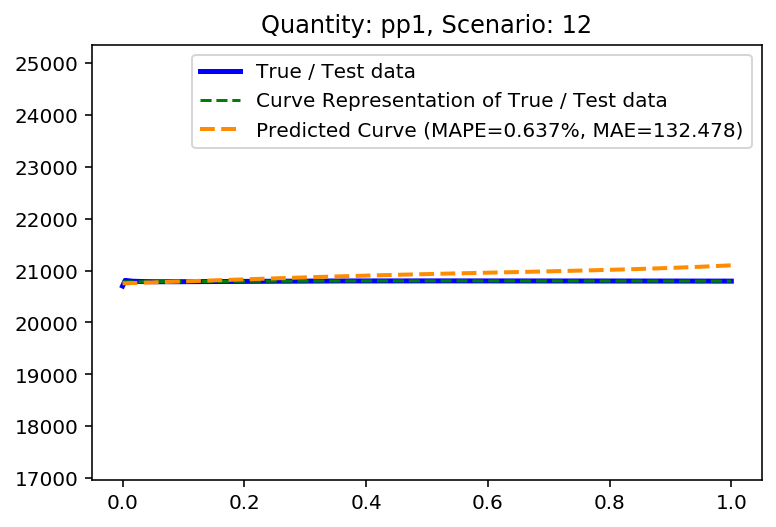

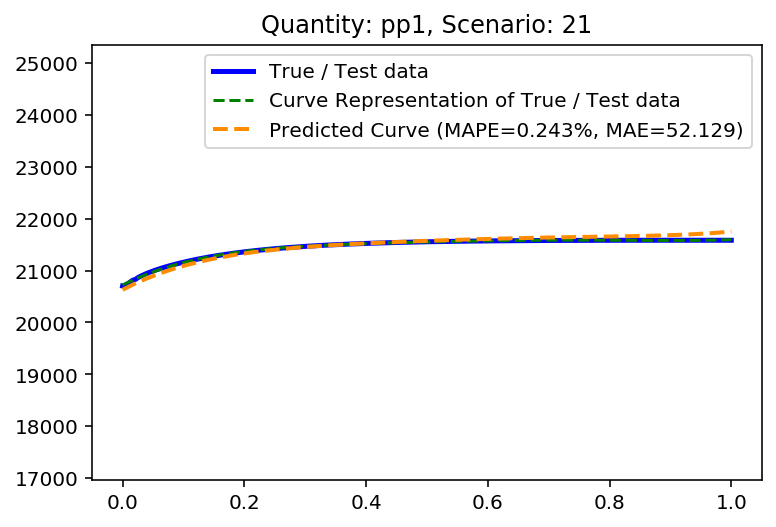

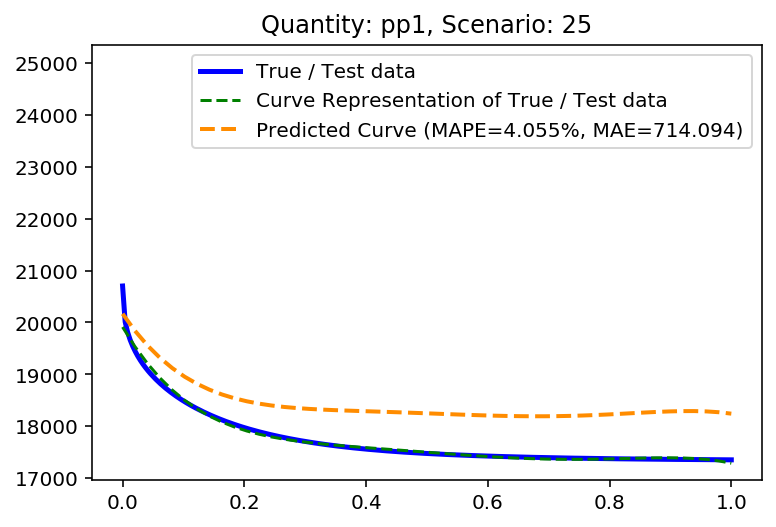

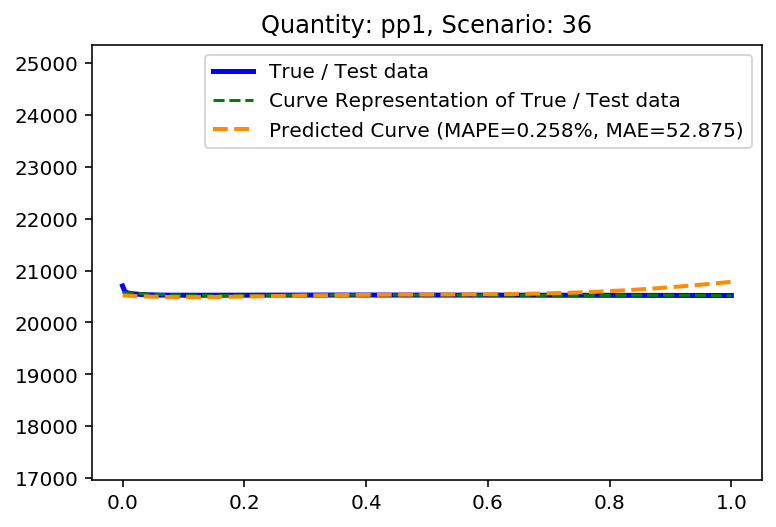

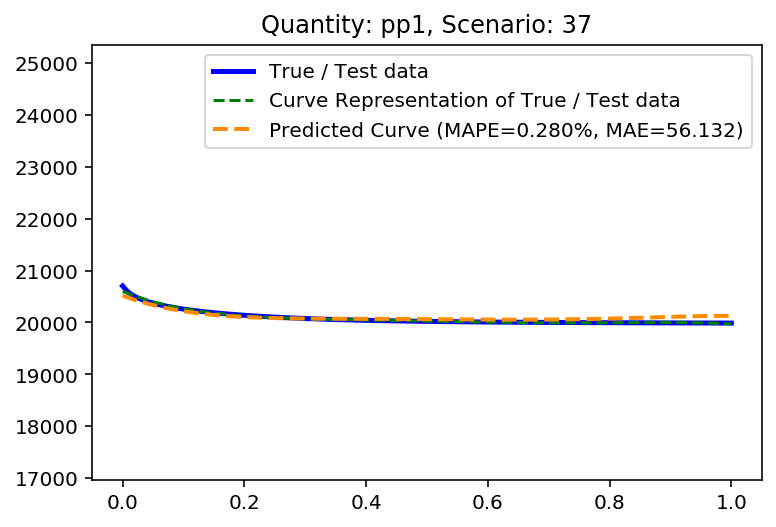

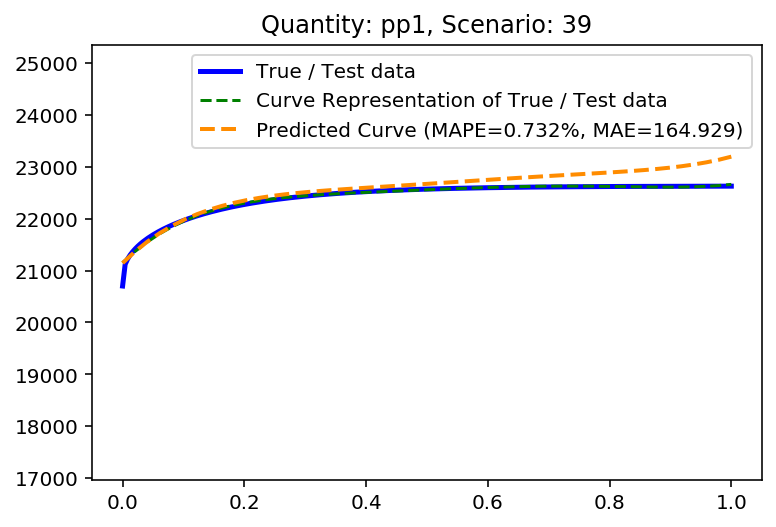

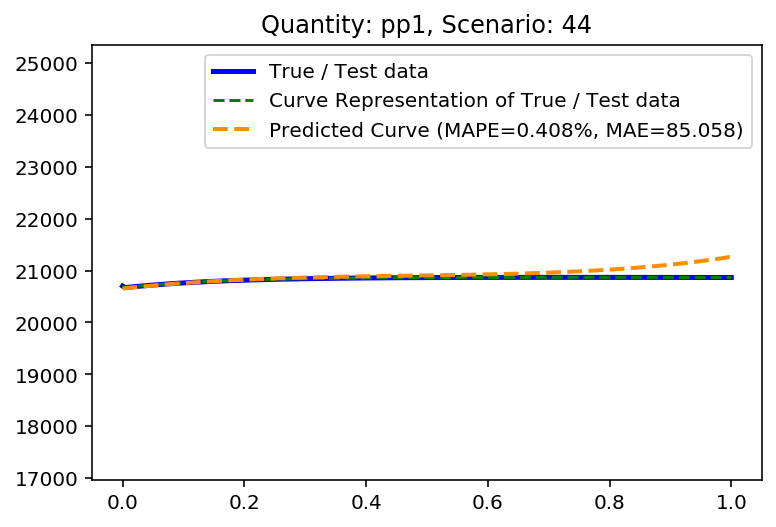

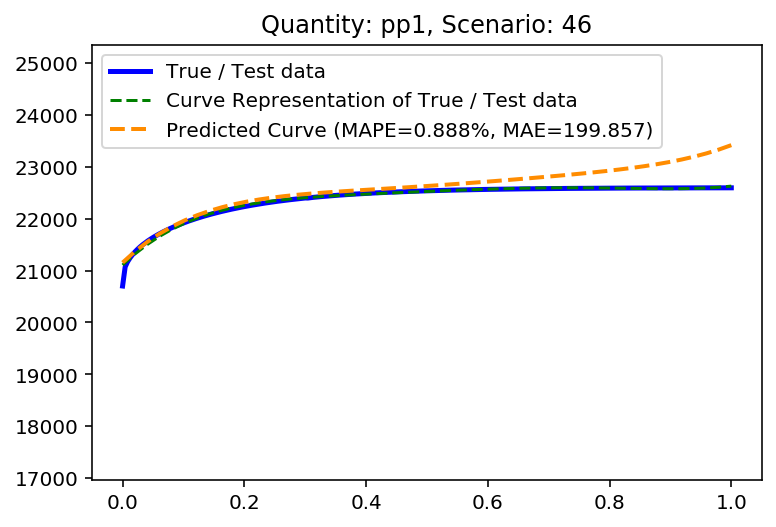

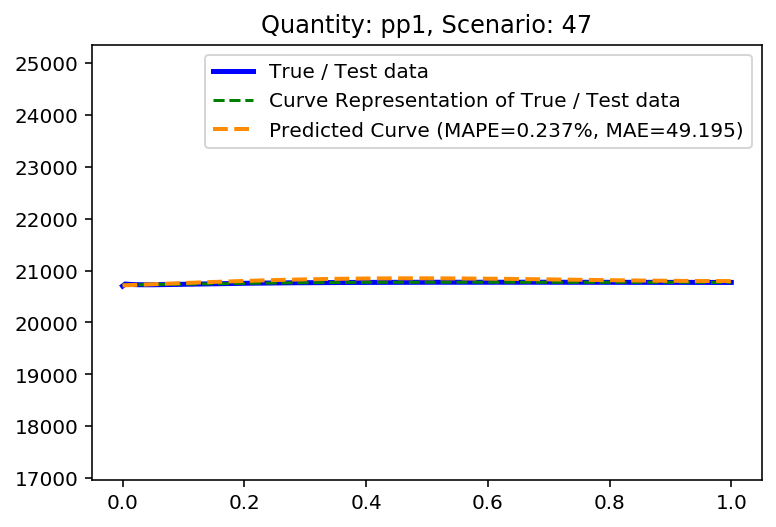

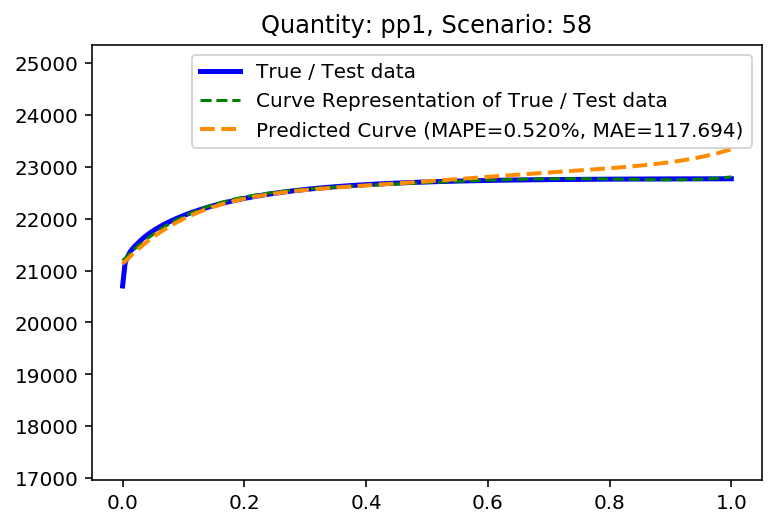

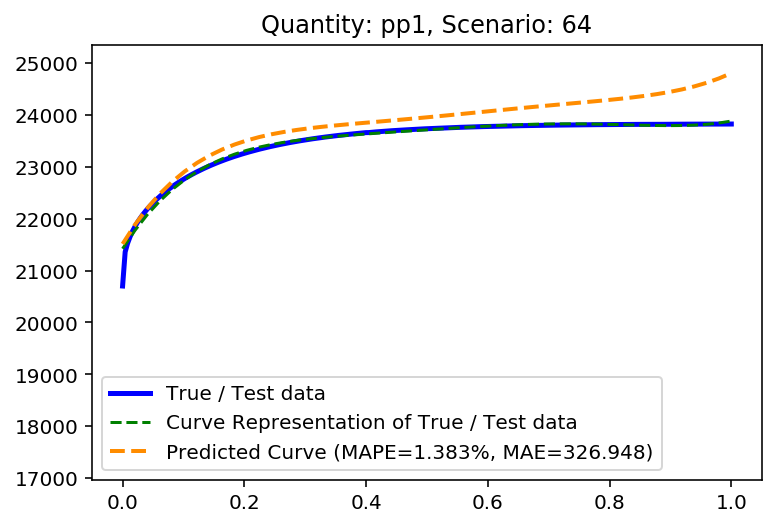

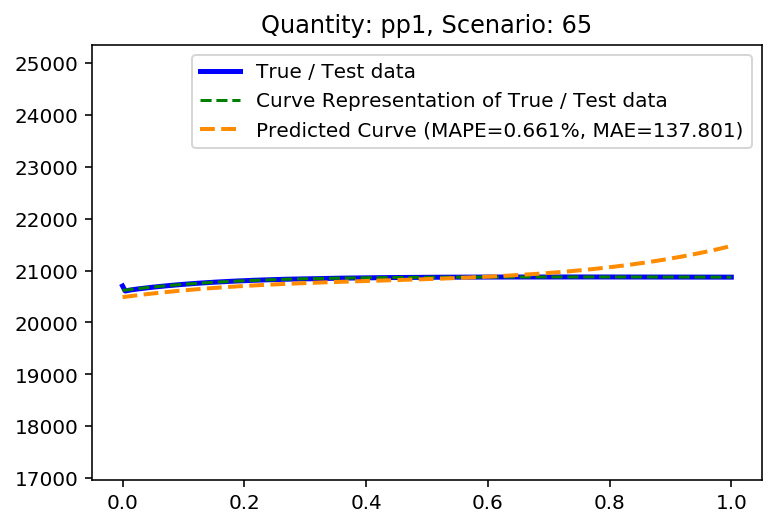

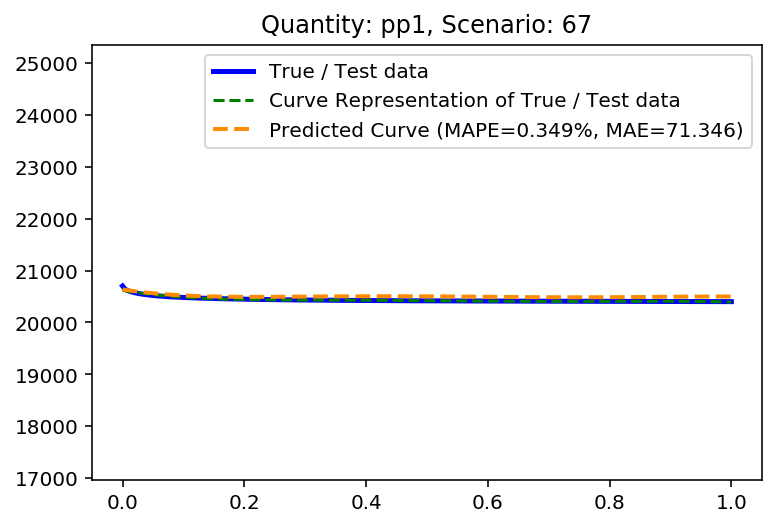

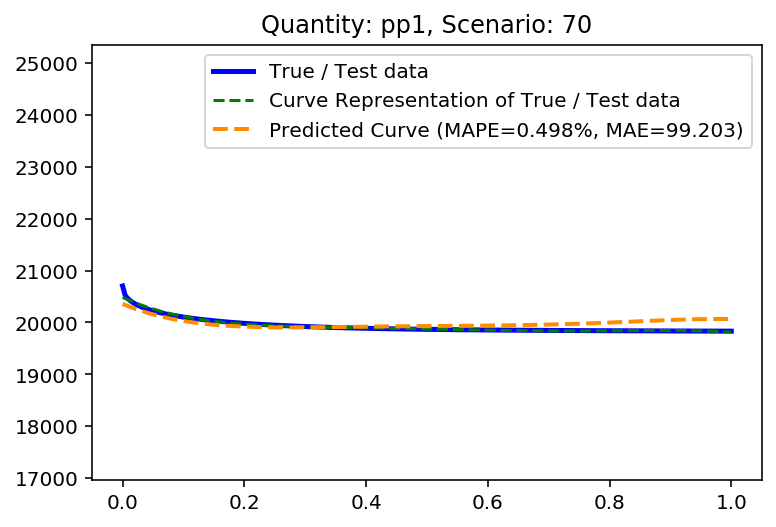

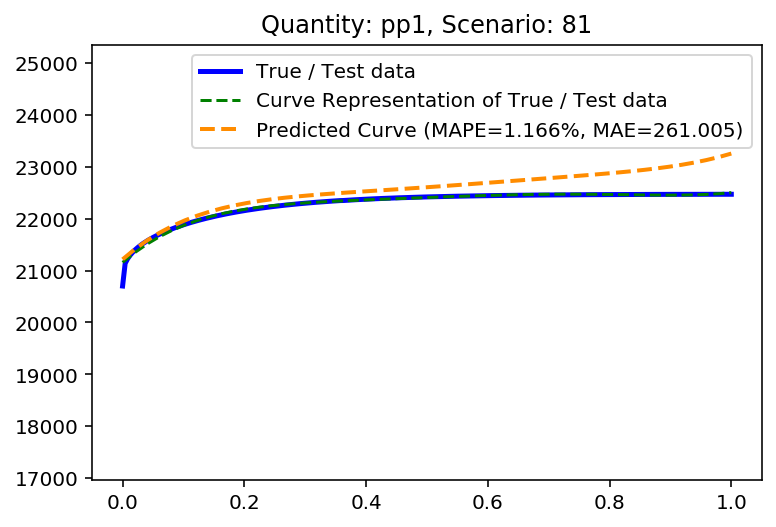

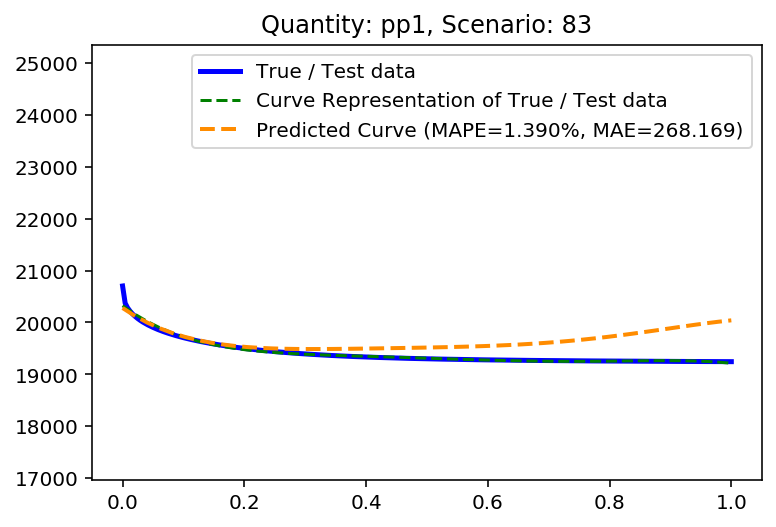

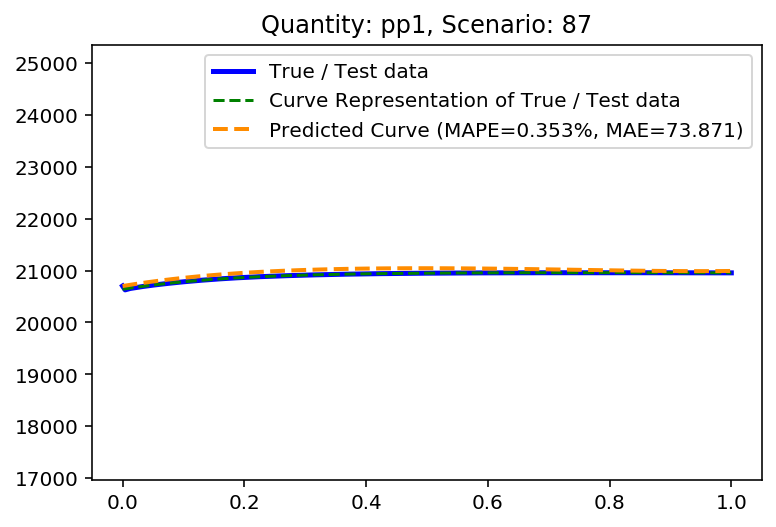

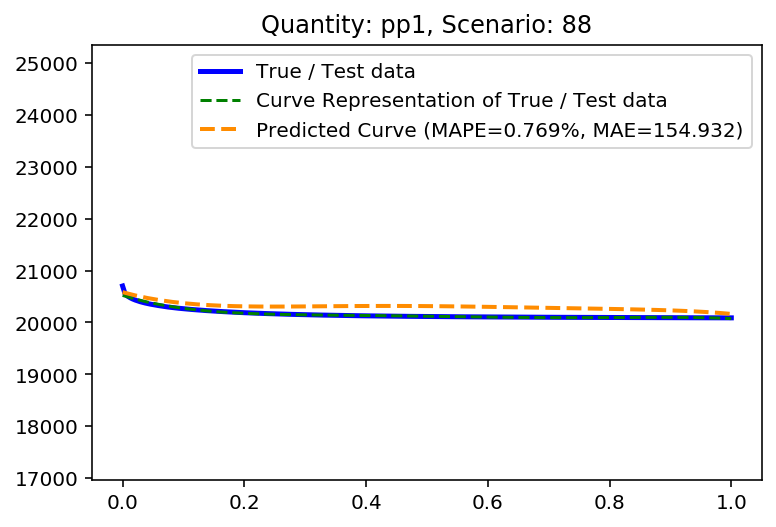

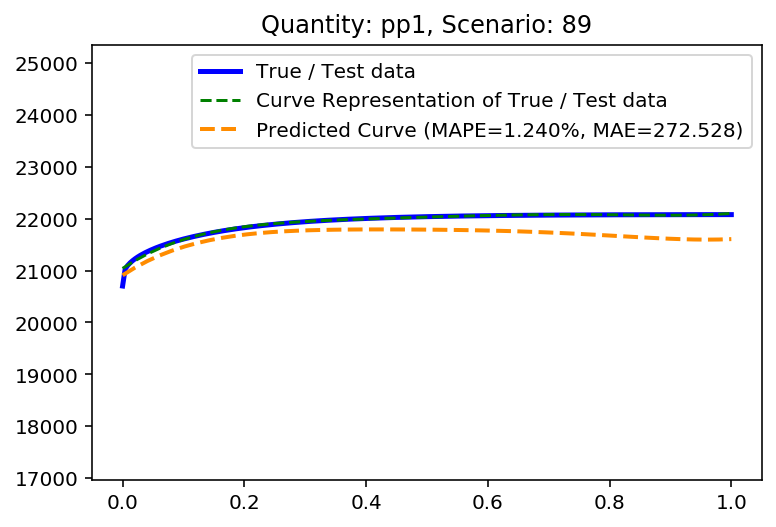

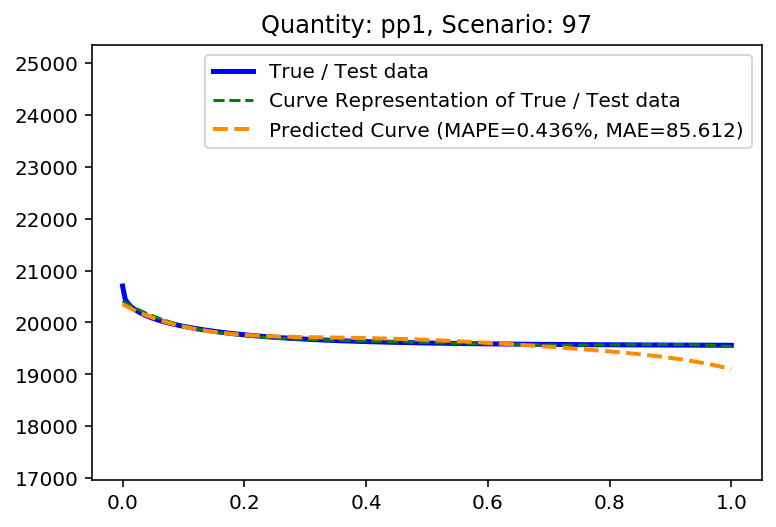

,timestamp,model_uuid,quantity,degree,nn,n_epochs,loss,validation_split_ratio,val_number_of_iters_to_agg,test_case_count,split_id,test_cases,val_err_avg_last_iters,test_case_id,mape,mae,mape_curve_only_no_prediction
0,2021-12-30 12:57:04.463125,4fdf0d78-dae2-40e9-a861-6d04d286394d,pp1,5,32,1000,mae,0.0,20,21,0,"[9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64...",None,9,0.760212,148.398589,0.068252
1,2021-12-30 12:57:04.755420,4fdf0d78-dae2-40e9-a861-6d04d286394d,pp1,5,32,1000,mae,0.0,20,21,0,"[9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64...",None,12,0.636963,132.477664,0.005110
2,2021-12-30 12:57:04.916659,4fdf0d78-dae2-40e9-a861-6d04d286394d,pp1,5,32,1000,mae,0.0,20,21,0,"[9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64...",None,21,0.243130,52.128647,0.022338
3,2021-12-30 12:57:05.077238,4fdf0d78-dae2-40e9-a861-6d04d286394d,pp1,5,32,1000,mae,0.0,20,21,0,"[9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64...",None,25,4.055380,714.094444,0.176625
4,2021-12-30 12:57:05.237646,4fdf0d78-dae2-40e9-a861-6d04d286394d,pp1,5,32,1000,mae,0.0,20,21,0,"[9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64...",None,36,0.257601,52.874989,0.018408
5,2021-12-30 12:57:05.408110,4fdf0d78-dae2-40e9-a861-6d04d286394d,pp1,5,32,1000,mae,0.0,20,21,0,"[9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64...",None,37,0.279716,56.132496,0.036849
6,2021-12-30 12:57:05.568889,4fdf0d78-dae2-40e9-a861-6d04d286394d,pp1,5,32,1000,mae,0.0,20,21,0,"[9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64...",None,39,0.731916,164.929164,0.076811
7,2021-12-30 12:57:05.730142,4fdf0d78-dae2-40e9-a861-6d04d286394d,pp1,5,32,1000,mae,0.0,20,21,0,"[9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64...",None,44,0.407688,85.058269,0.002512
8,2021-12-30 12:57:05.890578,4fdf0d78-dae2-40e9-a861-6d04d286394d,pp1,5,32,1000,mae,0.0,20,21,0,"[9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64...",None,46,0.887587,199.856971,0.072880
9,2021-12-30 12:57:06.052687,4fdf0d78-dae2-40e9-a861-6d04d286394d,pp1,5,32,1000,mae,0.0,20,21,0,"[9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64...",None,47,0.236868,49.194800,0.005079


In [4]:
##########################
# Setting key parameters #
##########################

batch_id = "OSR-TEST"

#quantity_list = ["pp1", "pp2", "pp3", "pp4", "pp5", "pp6", "pt1", "pt2", "pt3", "pt4", "pt5", "pt6"]
quantity = "pp1"

degree = 5

nn = 32
n_epochs = 1000
loss = "mae" # mae or mse
validation_split_ratio = 0.0 # Ratio of train set that will be treated as validation set

n_splits = 1

val_number_of_iters_to_agg = 20
plotting = True

res_dir = "../results/error_summaries/"
model_dir = "../models/"

save_to_disk = False

##################################
# All key parameters are set now #
##################################

poly = get_polynomial_func(degree=degree)

if quantity in ["pp1", "pp2", "pp3", "pp4", "pp5", "pp6"]:
    scaler = ens.common_pres_scaler
elif quantity in ["pt1", "pt2", "pt3", "pt4", "pt5", "pt6"]:
    scaler = ens.common_temp_scaler

t_mapper = ens.shared_scaled_time_index(start_at='2020-01-01')
#t_mapper = {k: v+1.0 for k,v in t_mapper.items()}

r2_vector = []
rmse_vector = []

quantity_min = math.inf
quantity_max = -math.inf

ydata_df = pd.DataFrame(index=sorted(t_mapper.values()), columns=range(ens.count))
yhat_df = pd.DataFrame(index=sorted(t_mapper.values()), columns=range(ens.count))

coeff_df, starting_points, quantity_min_max = ens.get_curve_approximations(quantity, poly)

error_summary_df = pd.DataFrame(columns = [
    "timestamp", "model_uuid",
    "quantity", "degree", "nn", "n_epochs", "loss", 
    "validation_split_ratio", "val_number_of_iters_to_agg", "test_case_count",
    "split_id", "test_cases", "val_err_avg_last_iters", "test_case_id", 
    "mape", "mae", "mape_curve_only_no_prediction"])

for split_id in range(n_splits):
    # Every time -- new split, but the overall set of n_splits is same from run to run
    np.random.seed(split_id)
    #tf.random.set_seed(split_id)
    
    train_set, validate_set, test_set = ens.split_cases(printing=False)  
    test_case_count = len(test_set)
    train_and_validate_idx = train_set # list(mlmodel.split_info['Train']) + list(mlmodel.split_info['Validate'])

    # Form a dataframe with all controlled parameter values
    m_column_list = ["im1", "im2", "im3", "im4"]
    injector_df = pd.DataFrame(index=range(ens.count), columns=m_column_list)
    for i in range(ens.count):
        df = ens[i].scaled_timeseries[m_column_list]
        df = df[df.index >= pd.to_datetime('2020-01-01')]

        for c in m_column_list:
            # Important: this characterizes a timeseries by its most common values; different methods can be used here
            # This works well for the step function
            injector_df.at[i, c] = df[c].value_counts().index[0]

    m_column_list = ["pm1", "pm2", "pm3", "pm4", "pm5", "pm6"]
    producer_df = pd.DataFrame(index=range(ens.count), columns=m_column_list)
    for i in range(ens.count):
        df = ens[i].scaled_timeseries[m_column_list]
        df = df[df.index >= pd.to_datetime('2020-01-01')]

        for c in m_column_list:
            # Important: this characterizes a timeseries by its most common values; different methods can be used here
            # This works well for the step function
            producer_df.at[i, c] = df[c].value_counts().index[0]

    all_wells_df = injector_df.join(producer_df)

    #print("Input for Curve ML training:")
    X_train = all_wells_df.loc[train_and_validate_idx]
    #display(X_train)

    #print("Output for Curve ML training:")
    Y_train = coeff_df.loc[train_and_validate_idx]
    #display(Y_train)

    X_test = all_wells_df.loc[test_set]
    Y_test = coeff_df.loc[test_set]

    # initialize model
    model = Sequential()

    # add 1st layer
    model.add(Dense(
        units=nn,
        input_dim=X_train.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh') 
    )
    # add 2nd layer
    model.add(
        Dense(
            units=nn,
            input_dim=nn,
            kernel_initializer='glorot_uniform',
            bias_initializer='zeros',
            activation='tanh')
        )
    # add output layer
    model.add(
        Dense(
            units=Y_train.shape[1],
            input_dim=nn,
            kernel_initializer='glorot_uniform',
            bias_initializer='zeros',
            activation=None)
        )

    # define SGD optimizer
    sgd_optimizer = SGD(
        lr=0.001, decay=1e-7, momentum=0.9
    )
    # compile model

    model.compile(
        optimizer=sgd_optimizer,
        loss=loss
    )

    X_train_converted=np.asarray(X_train).astype(np.float32)
    Y_train_converted=np.asarray(Y_train).astype(np.float32)

    #print(model.summary())

    #train model
    history = model.fit(
        X_train_converted, Y_train_converted,
        batch_size=1, epochs=n_epochs,
        verbose=0, 
        validation_split=validation_split_ratio
    )
    
    # Random UUID
    model_uuid = uuid.uuid4()
    if save_to_disk:
        model.save(os.path.join(model_dir, str(model_uuid)))
    
    if 'val_loss' in history.history:
        # Average (across last val_number_of_iters_to_agg epochs) to make estimates more reliable than individual step's error values
        val_err_avg_last_iters = np.mean(history.history['val_loss'][-val_number_of_iters_to_agg:])
    else:
        val_err_avg_last_iters = None

    X_test=np.asarray(X_test).astype(np.float32)
    Y_test=np.asarray(Y_test).astype(np.float32)

    # Predicted coefficients
    Y_test_pred = model.predict(X_test, verbose=0)

    xdata = np.linspace(0, 1.0, 50)
    for coeff_true, coeff_pred, test_case_id in zip(Y_test, Y_test_pred, test_set):
        one_traj = ens[test_case_id].scaled_timeseries[quantity]
        one_traj = one_traj[one_traj.index >= pd.to_datetime('2020-01-01')]
        xdata_for_true_data = np.array(one_traj.index.map(t_mapper))
        ydata_not_fitted = one_traj.values

        ydata_true = poly(xdata, *coeff_true)
        ydata_pred = poly(xdata, *coeff_pred)
        ydata_pred_for_error_est = poly(xdata_for_true_data, *coeff_pred)

        mape = mean_absolute_percentage_error(scaler.inverse_transform(ydata_not_fitted.reshape(-1, 1)).reshape(-1,), 
                                              scaler.inverse_transform(ydata_pred_for_error_est.reshape(-1, 1)).reshape(-1,))
        mae = mean_absolute_error(scaler.inverse_transform(ydata_not_fitted.reshape(-1, 1)).reshape(-1,),
                                  scaler.inverse_transform(ydata_pred_for_error_est.reshape(-1, 1)).reshape(-1,))

        # For better monitoring, adding error measure between fitted curve and true data
        ydata_fitted_curve = poly(xdata_for_true_data, *coeff_true)
        mape_curve_only_no_prediction = mean_absolute_percentage_error(
            scaler.inverse_transform(ydata_not_fitted.reshape(-1, 1)).reshape(-1,), 
            scaler.inverse_transform(ydata_fitted_curve.reshape(-1, 1)).reshape(-1,))
    
        now = datetime.now()
        error_summary_df.loc[len(error_summary_df)] = [
            now, model_uuid,
            quantity, degree, nn, n_epochs, loss, 
            validation_split_ratio, val_number_of_iters_to_agg, test_case_count,
            split_id, test_set, val_err_avg_last_iters, test_case_id, 
            mape, mae, mape_curve_only_no_prediction]

        if plotting:
            plt.plot(xdata_for_true_data, 
                 scaler.inverse_transform(ydata_not_fitted.reshape(-1, 1)).reshape(-1,), 
                 'b-', label="True / Test data", linewidth=2.5)
            plt.plot(xdata, 
                 scaler.inverse_transform(ydata_true.reshape(-1, 1)).reshape(-1,), 
                 'g--', label="Curve Representation of True / Test data")
            plt.plot(xdata, 
                 scaler.inverse_transform(ydata_pred.reshape(-1, 1)).reshape(-1,), '--', c="darkorange",
                 label="Predicted Curve (MAPE=%.3f%%, MAE=%.3f)" % (mape, mae), linewidth=2.0)

            quantity_min_max_row = quantity_min_max[quantity_min_max["quantity"] == quantity]
            if len(quantity_min_max_row) == 1:
                qmin = quantity_min_max_row["quantity_min"].values[0]
                qmax = quantity_min_max_row["quantity_max"].values[0]
                qrange = qmax - qmin
                plt.ylim([qmin-qrange*0.05, qmax+qrange*0.05])
            plt.legend()
            plt.title("Quantity: %s, Scenario: %s" % (quantity, test_case_id))
            plt.show()
                
display(error_summary_df)

# Another random UUID
file_uuid = uuid.uuid4()
if save_to_disk:
    error_summary_df.to_csv(os.path.join(res_dir, "batch-%s-%s.csv" % (str(batch_id), str(file_uuid))), index=False)

Average MAPE: 0.8220735029942716


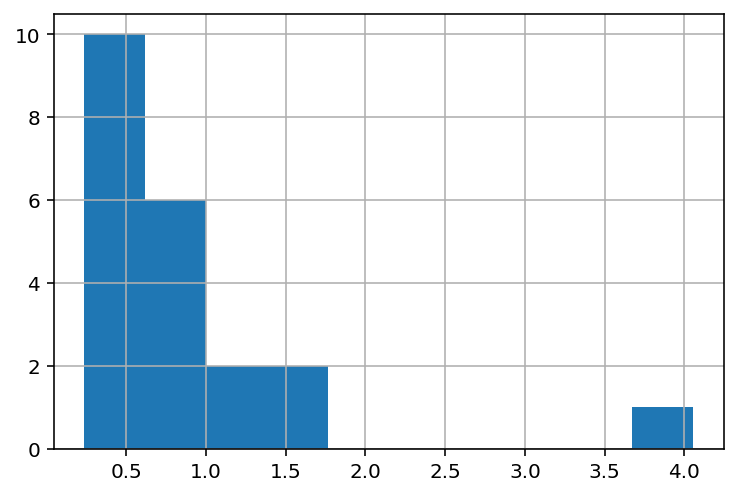

In [5]:
# Display a histogram of observed MAPE values

error_summary_df["mape"].hist()
print("Average MAPE:", error_summary_df["mape"].mean())